In [18]:
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm import tqdm

In [19]:
import json
import os
from os.path import join as path_join


def load_data(path):
    tasks = pd.Series()
    for file_path in os.listdir(path):
        task_file = path_join(path, file_path)

        with open(task_file, 'r') as f:
            task = json.load(f)

        tasks[file_path[:-5]] = task
    return tasks

In [20]:
data_path = Path('input')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

train_tasks = load_data(training_path)
evaluation_tasks = load_data(evaluation_path)
test_tasks = load_data(test_path)

train_tasks.head()

C:\Users\iti_d\Anaconda3\envs\Licenta\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


007bbfb7    {'test': [{'input': [[7, 0, 7], [7, 0, 7], [7,...
00d62c1b    {'train': [{'input': [[0, 0, 0, 0, 0, 0], [0, ...
017c7c7b    {'train': [{'input': [[0, 1, 0], [1, 1, 0], [0...
025d127b    {'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...
045e512c    {'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...
dtype: object

In [21]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.nn import Conv2d
from torch import FloatTensor, LongTensor



def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img


class TaskSolver:        
    def train(self, task_train, n_epoch=30):
        """basic pytorch train loop"""
        self.net = Conv2d(in_channels=10, out_channels=10, kernel_size=5, padding=2)
        
        criterion = CrossEntropyLoss()
        optimizer = Adam(self.net.parameters(), lr = 0.1)
        
        for epoch in range(n_epoch):
            for sample in task_train:
                inputs = FloatTensor(inp2img(sample['input'])).unsqueeze(dim=0)
                labels = LongTensor(sample['output']).unsqueeze(dim=0)
                
                optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        return self
            
    def predict(self, task_test):
        predictions = []
        with torch.no_grad():
            for sample in task_test:
                inputs = FloatTensor(inp2img(sample['input'])).unsqueeze(dim=0)
                outputs = self.net(inputs)
                pred =  outputs.squeeze(dim=0).cpu().numpy().argmax(0)
                predictions.append(pred)
                                     
        return predictions


In [22]:
def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])

def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

In [23]:
def evaluate(tasks):
    ts = TaskSolver()
    result = []
    predictions = []
    for task in tqdm(tasks):
        if input_output_shape_is_same(task):
            ts.train(task['train'])
            pred = ts.predict(task['test'])
            score = calk_score(task['test'], pred)
        else:
            pred = [el['input'] for el in task['test']]
            score = [0]*len(task['test'])
        
        predictions.append(pred)
        result.append(score)
       
    return result, predictions

In [24]:
train_result, train_predictions = evaluate(train_tasks)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"train solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")

100%|██████████| 400/400 [00:48<00:00,  8.28it/s]


train solved : 11 from 416 (0.026442307692307692)


In [25]:
evaluation_result, evaluation_predictions = evaluate(evaluation_tasks)
evaluation_solved = [any(score) for score in evaluation_result]

total = sum([len(score) for score in evaluation_result])
print(f"evaluation solved : {sum(evaluation_solved)} from {total} ({sum(evaluation_solved)/total})")

100%|██████████| 400/400 [00:49<00:00,  8.13it/s]


evaluation solved : 4 from 419 (0.00954653937947494)


# Visualize

visualize solved tasks

In [26]:
import matplotlib.pyplot as plt
from matplotlib import colors


cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
    
def plot_pictures(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()
    

def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])

### train solved tasks

400it [00:11, 36.36it/s]


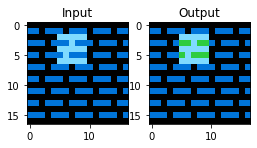

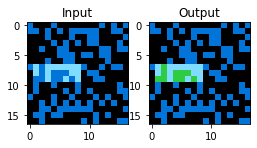

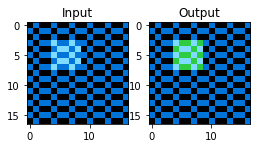

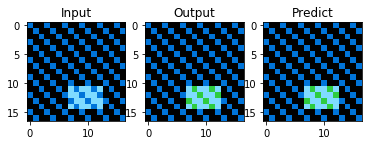

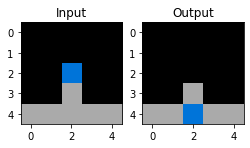

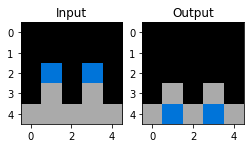

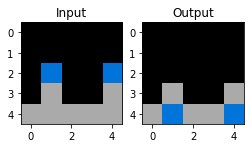

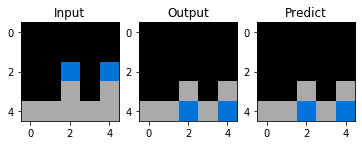

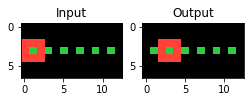

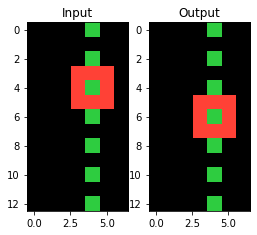

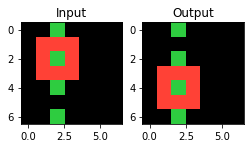

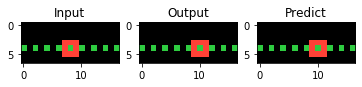

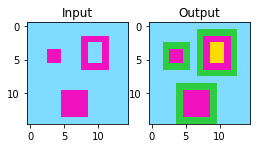

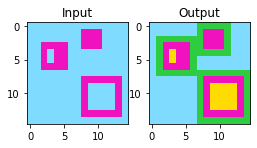

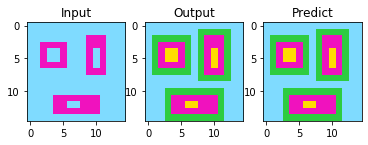

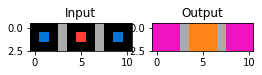

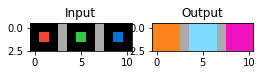

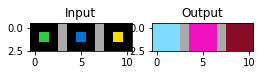

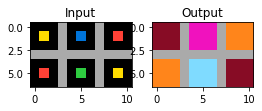

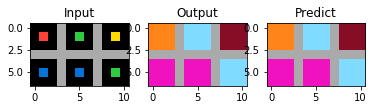

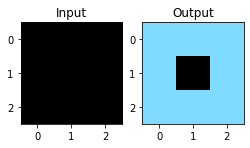

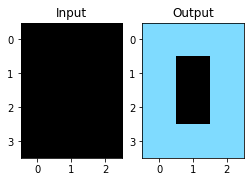

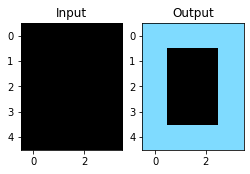

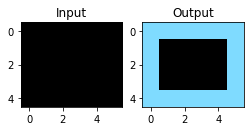

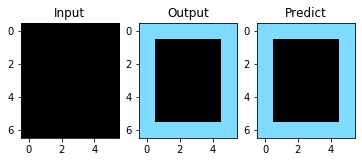

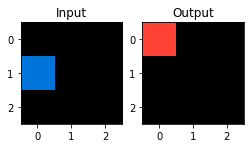

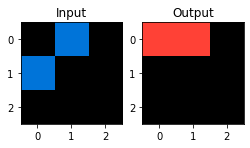

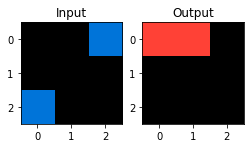

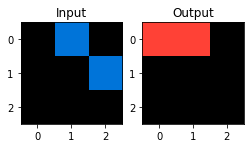

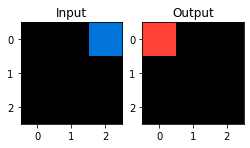

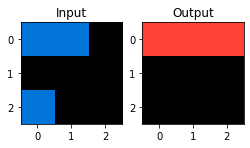

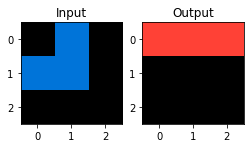

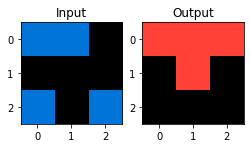

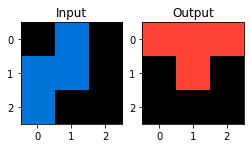

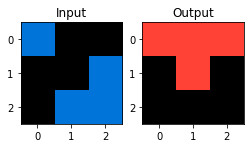

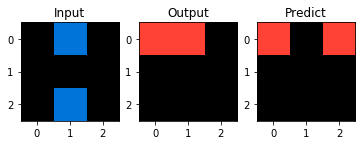

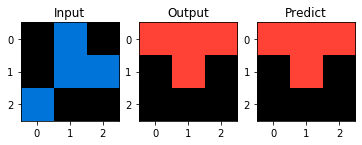

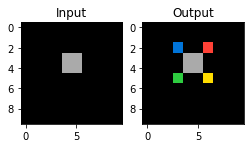

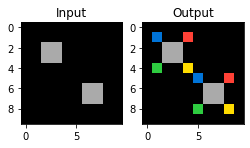

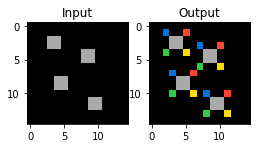

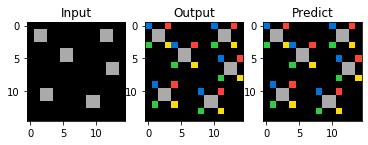

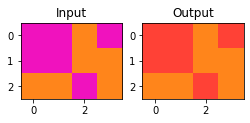

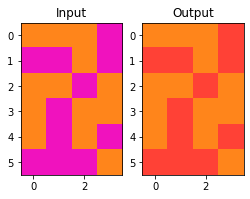

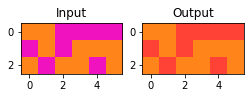

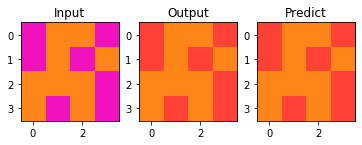

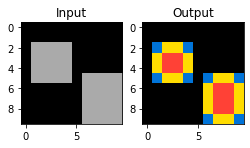

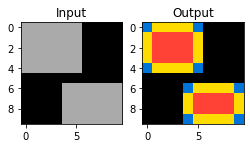

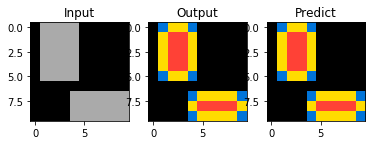

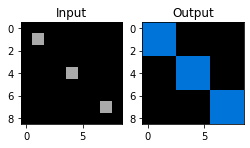

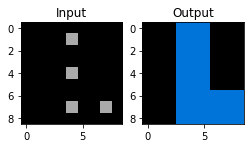

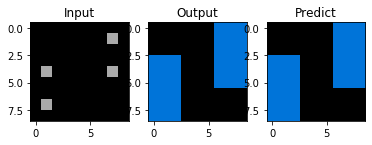

In [27]:
for task, prediction, solved in tqdm(zip(train_tasks, train_predictions, train_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

### evaluation solved tasks

400it [00:04, 86.06it/s]


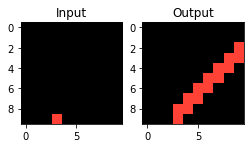

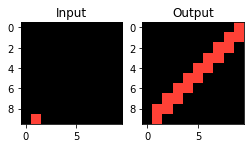

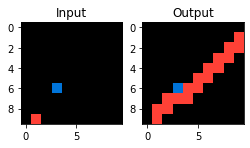

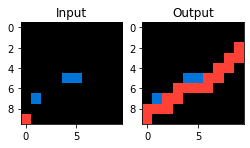

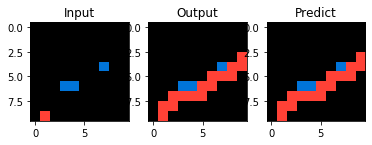

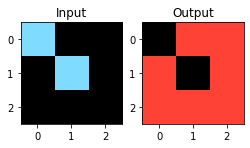

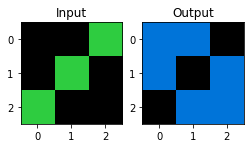

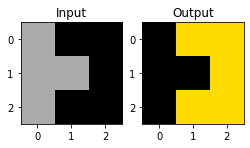

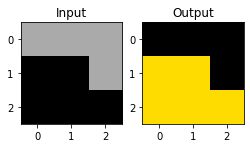

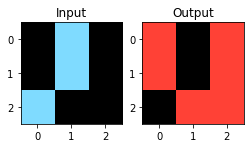

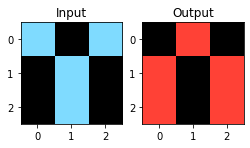

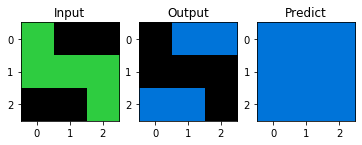

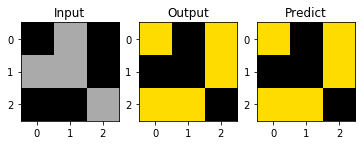

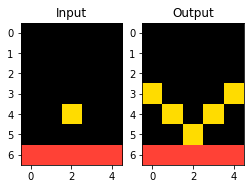

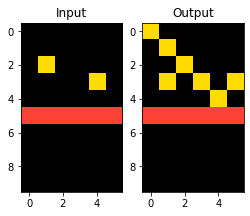

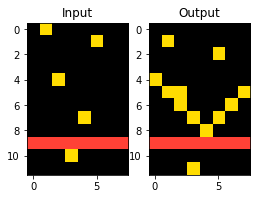

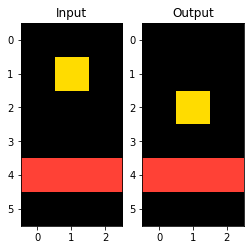

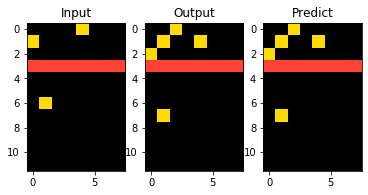

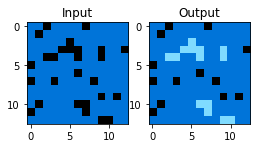

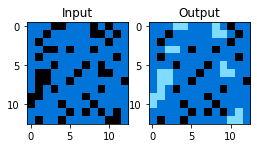

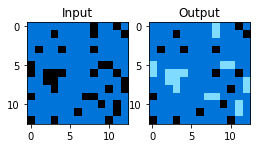

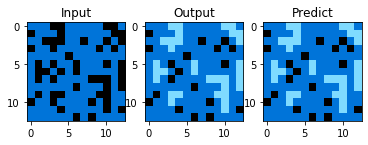

In [28]:
for task, prediction, solved in tqdm(zip(evaluation_tasks, evaluation_predictions, evaluation_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

# Prediction

In [29]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def make_pediction(tasks):
    ts = TaskSolver()
    result = pd.Series()
    for idx, task in tqdm(test_tasks.iteritems()):
        if input_output_shape_is_same(task):
            ts.train(task['train'])
            pred = ts.predict(task['test'])
        else:
            pred = [el['input'] for el in task['test']]
        
        for i, p in enumerate(pred):
            result[f'{idx}_{i}'] = flattener(np.array(p).tolist())
       
    return result

In [30]:
submission = make_pediction(test_tasks)
submission.head()

C:\Users\iti_d\Anaconda3\envs\Licenta\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()
100it [00:11,  8.59it/s]


00576224_0                                              |32|78|
009d5c81_0    |00000000000000|00000227222772|00000300020207|...
00dbd492_0    |04080000088222220000|02222222228288820000|024...
03560426_0    |4400000000|1800000000|0000000000|0000000000|0...
05a7bcf2_0    |000000000020000000080000000000|00000000002280...
dtype: object

# All train tasks predictions

400it [01:21,  4.88it/s]


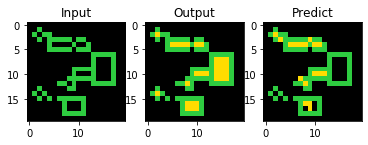

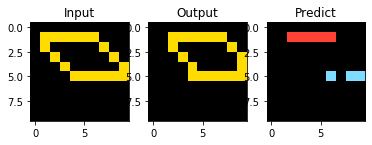

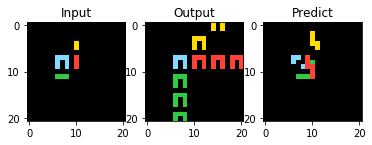

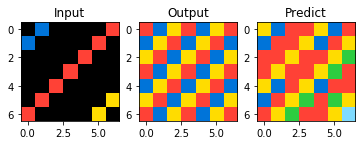

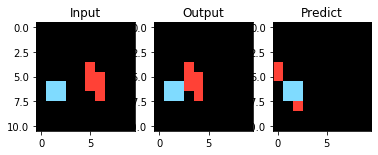

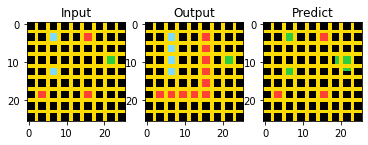

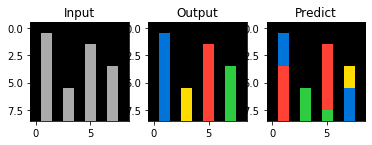

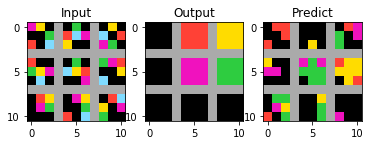

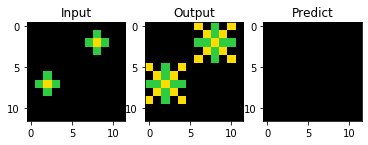

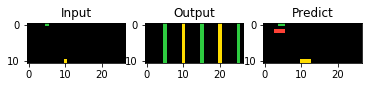

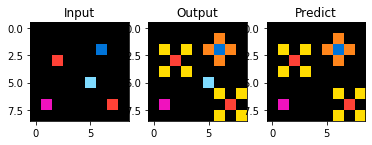

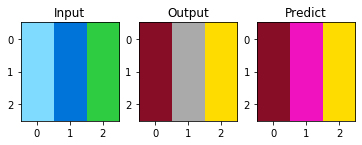

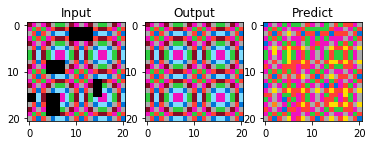

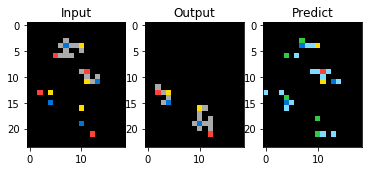

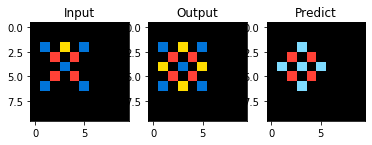

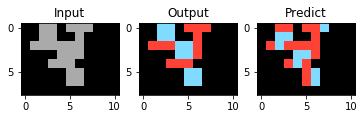

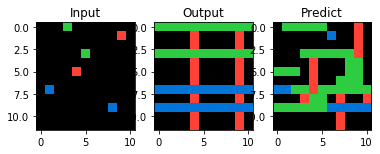

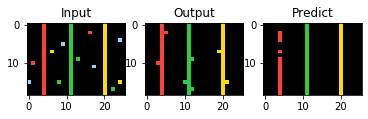

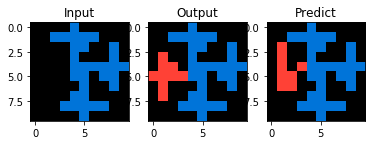

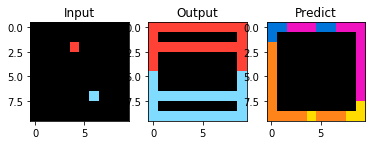

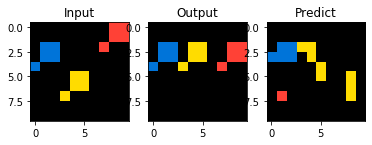

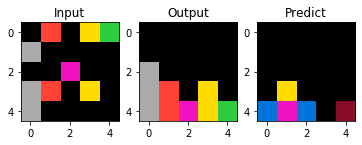

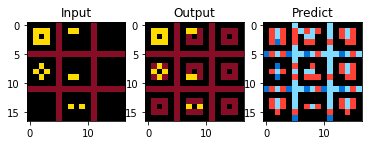

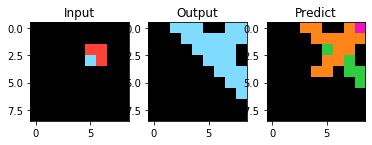

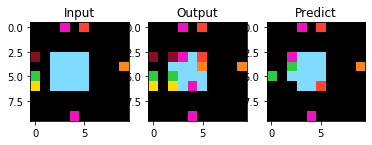

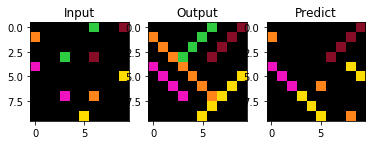

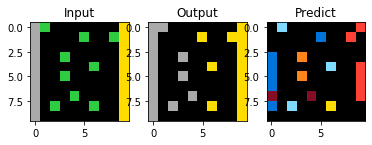

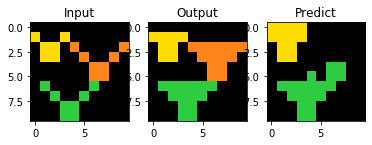

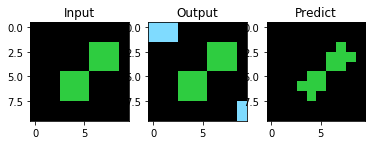

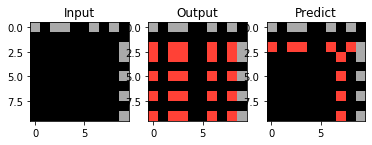

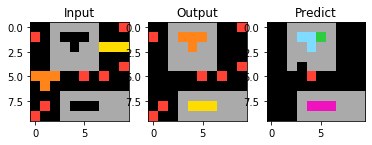

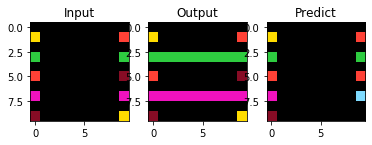

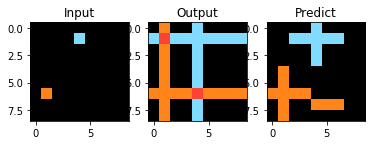

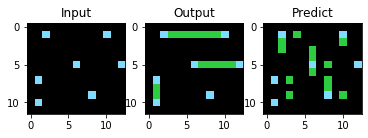

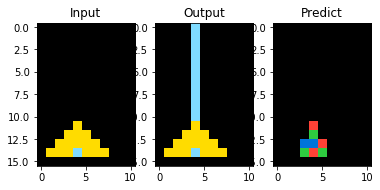

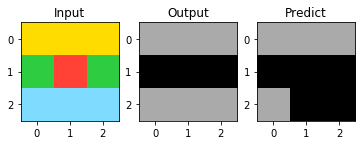

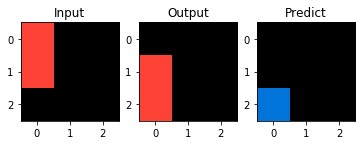

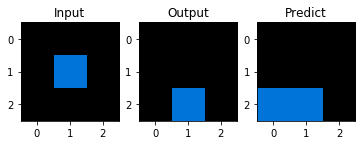

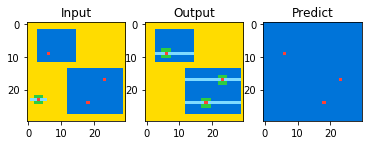

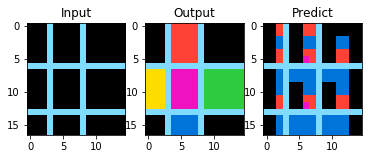

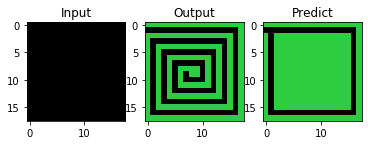

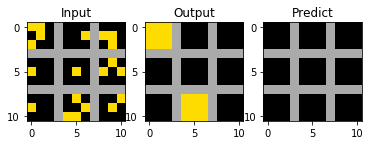

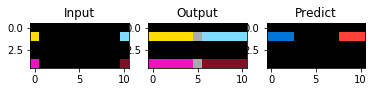

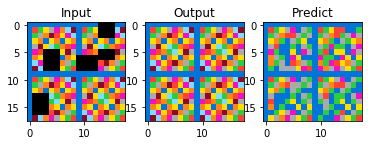

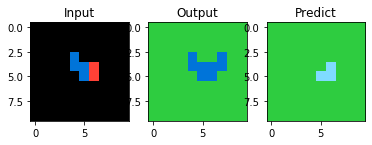

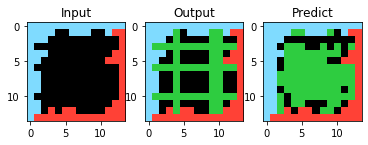

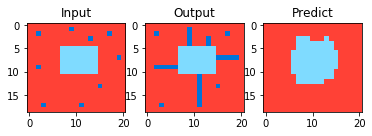

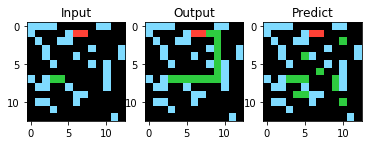

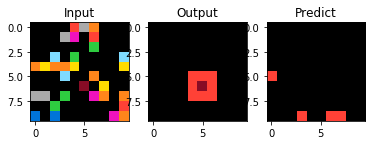

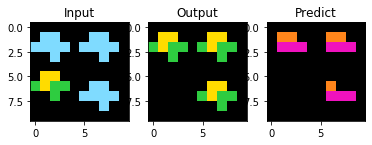

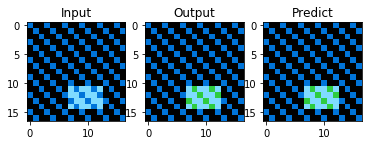

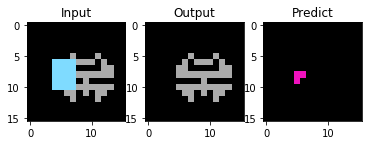

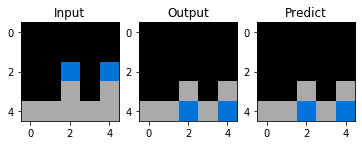

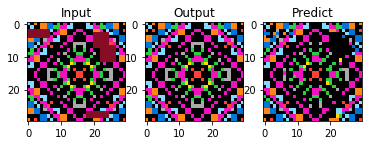

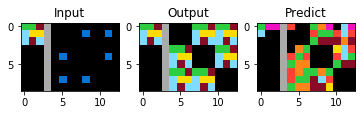

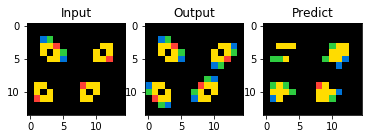

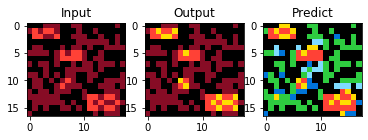

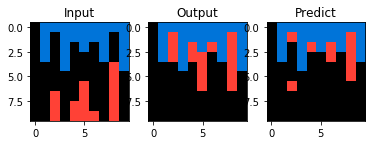

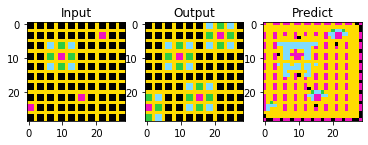

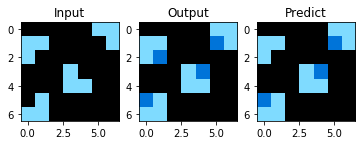

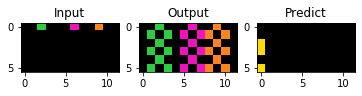

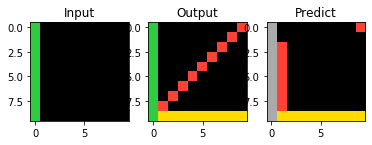

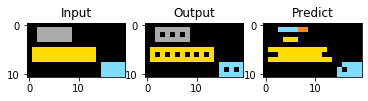

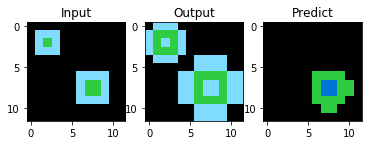

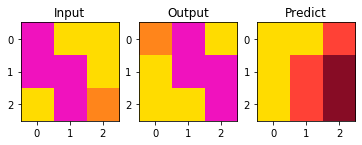

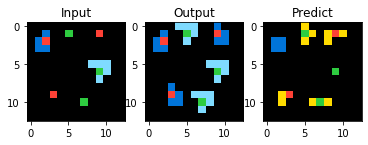

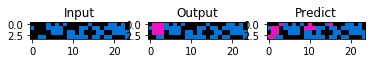

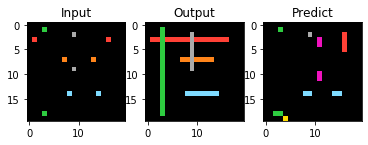

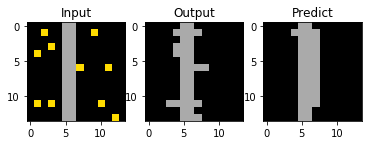

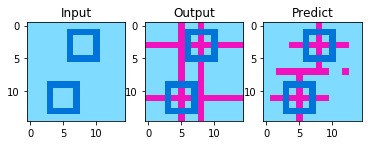

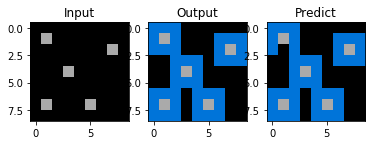

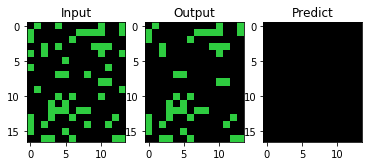

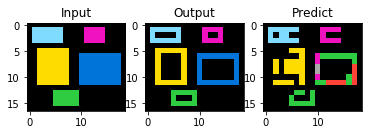

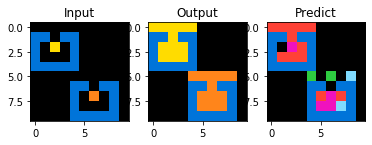

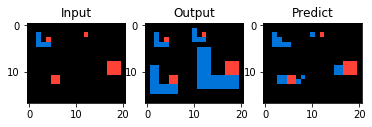

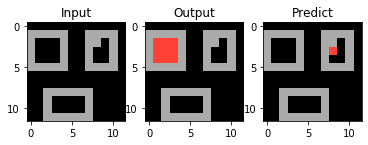

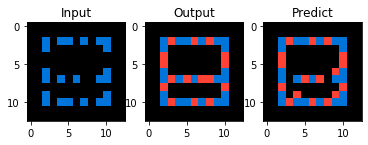

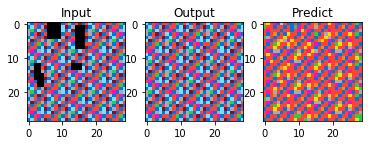

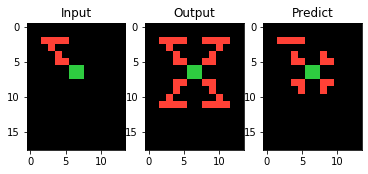

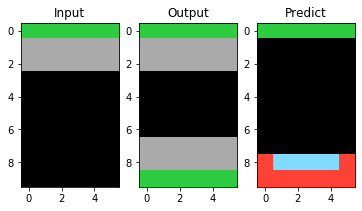

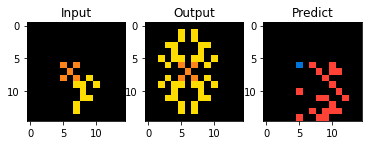

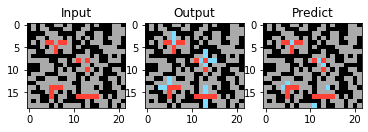

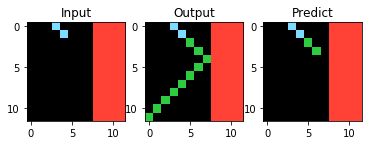

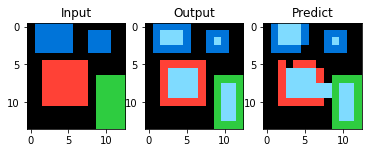

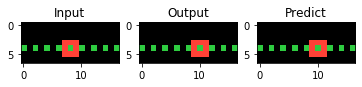

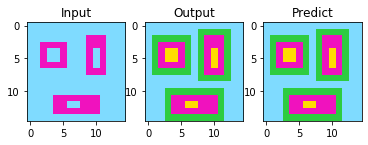

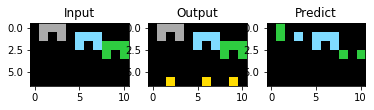

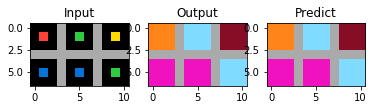

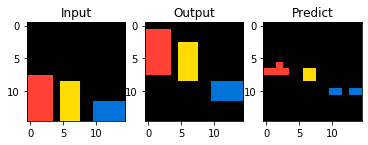

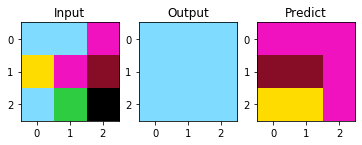

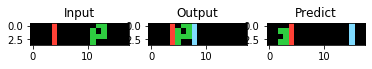

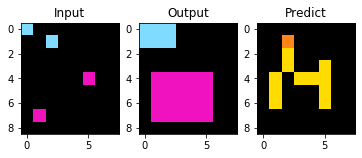

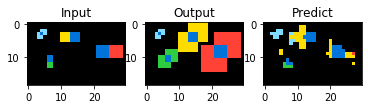

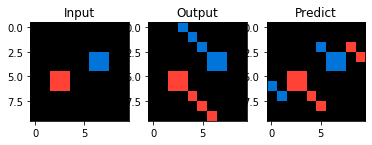

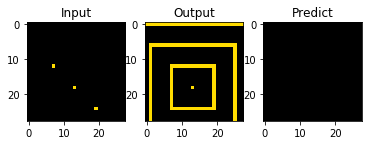

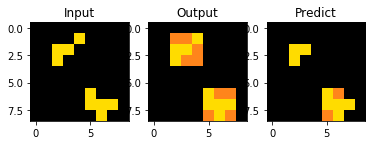

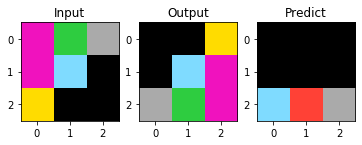

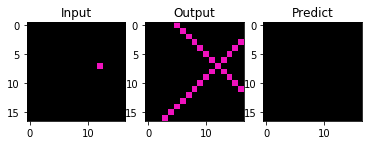

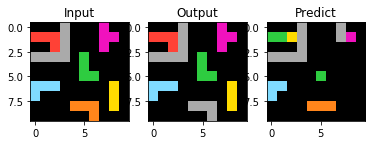

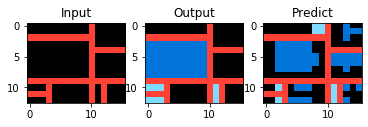

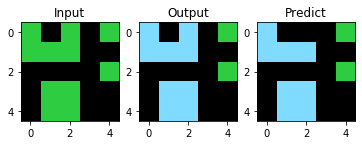

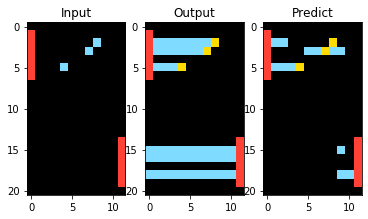

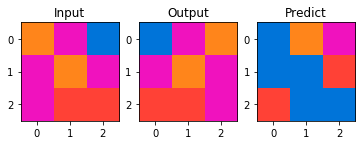

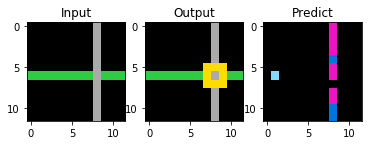

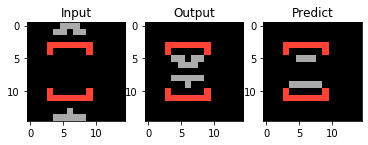

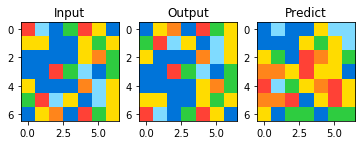

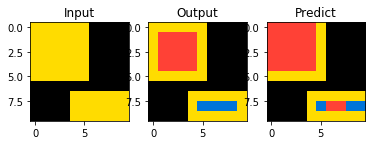

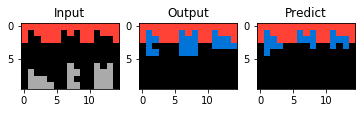

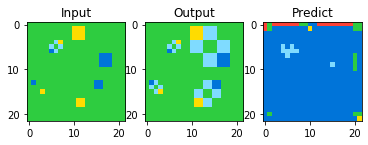

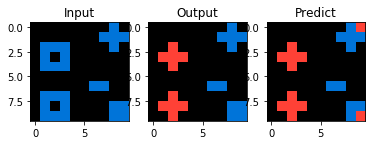

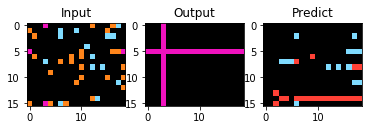

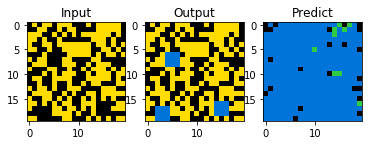

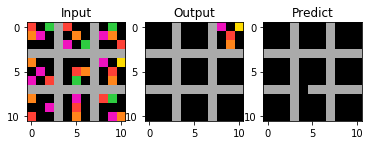

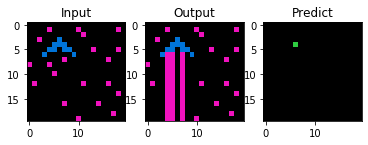

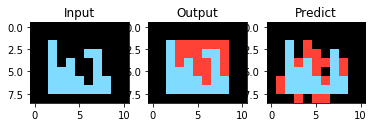

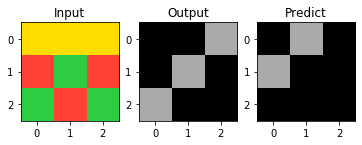

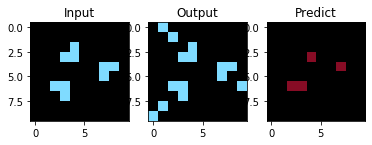

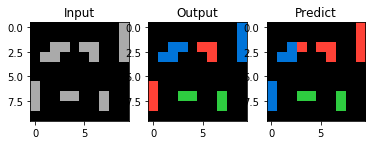

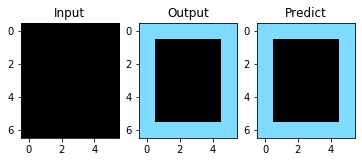

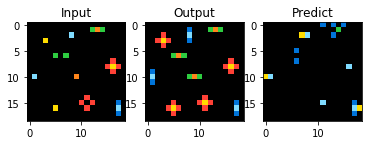

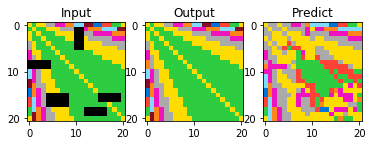

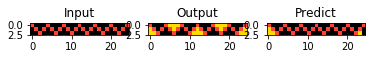

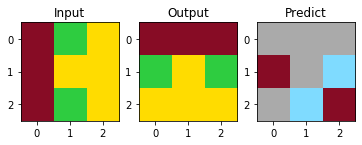

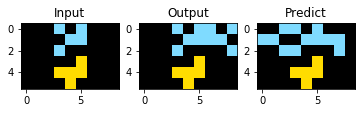

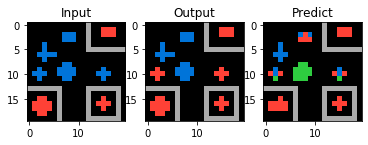

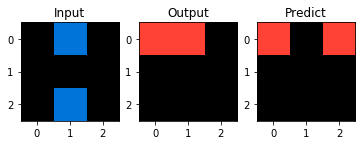

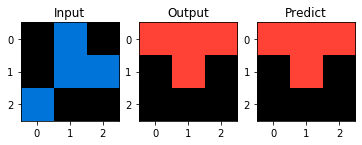

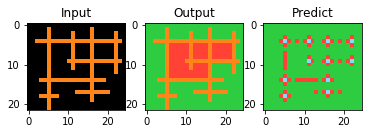

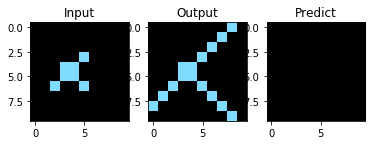

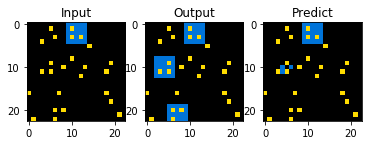

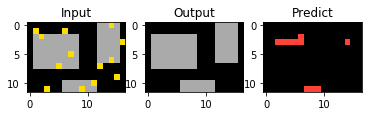

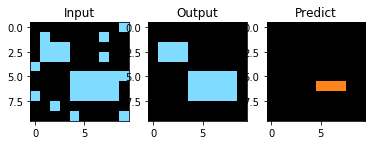

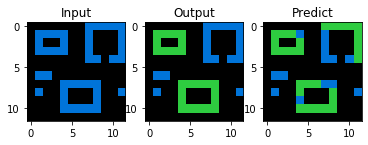

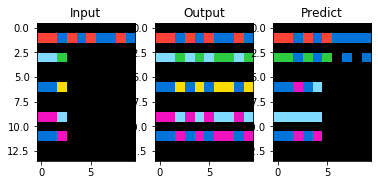

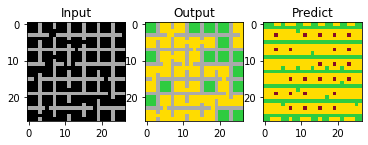

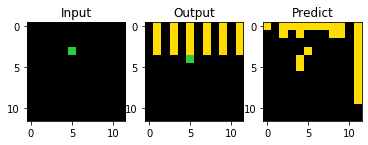

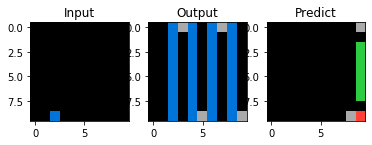

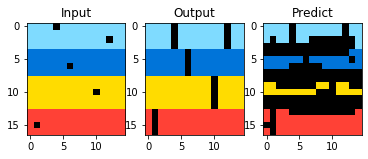

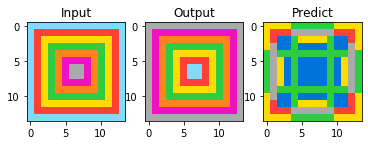

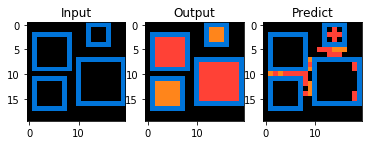

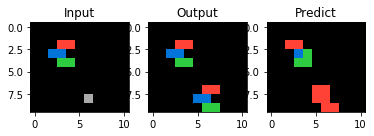

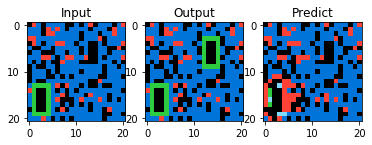

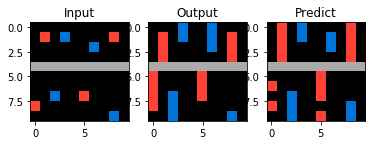

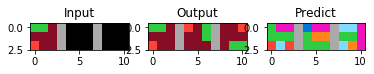

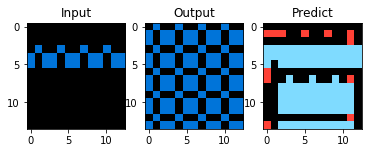

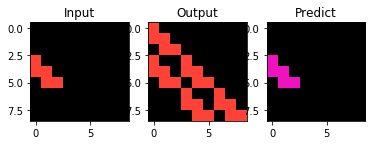

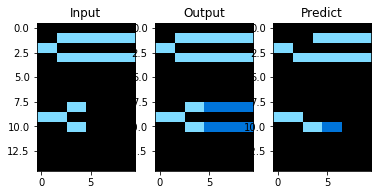

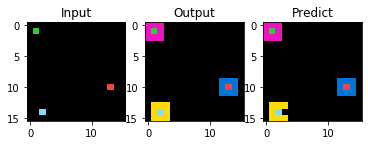

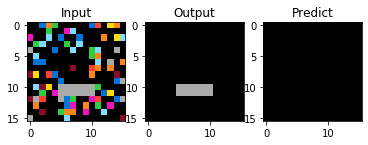

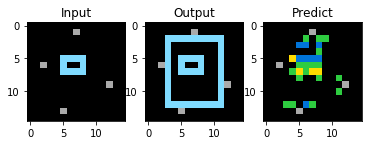

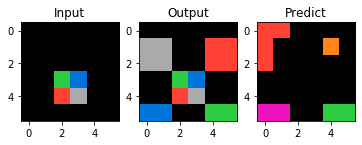

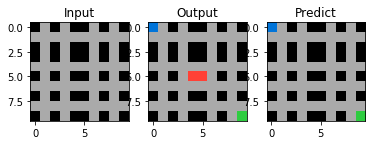

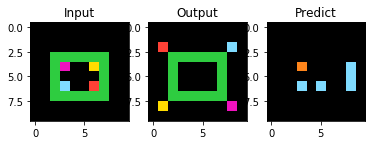

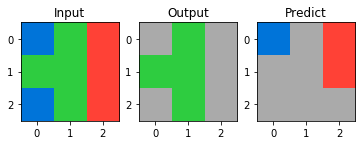

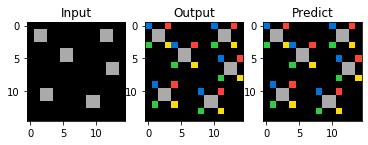

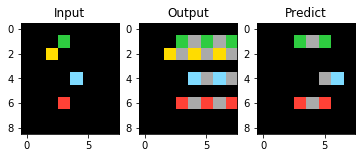

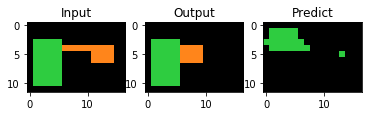

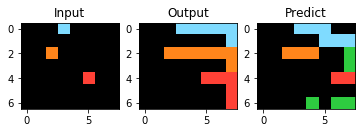

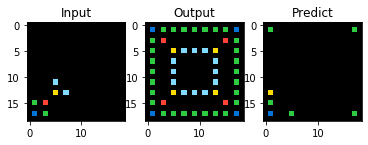

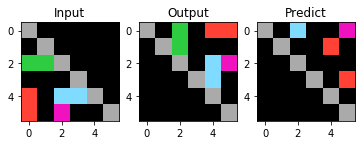

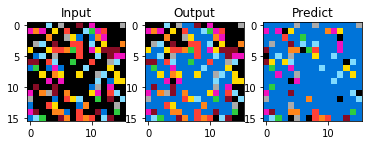

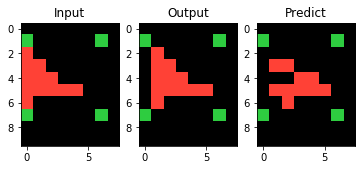

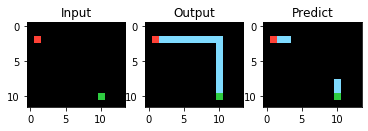

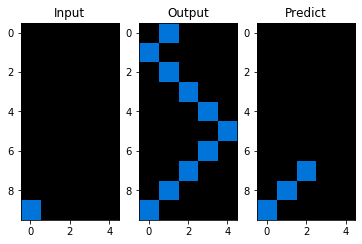

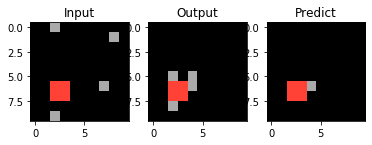

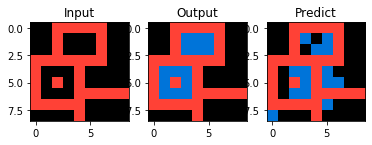

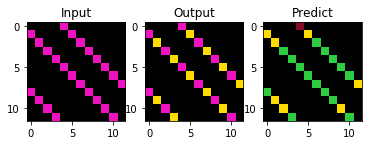

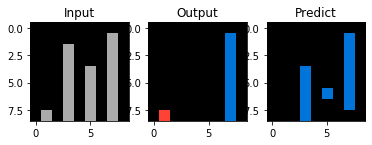

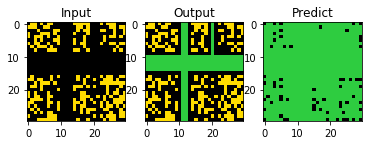

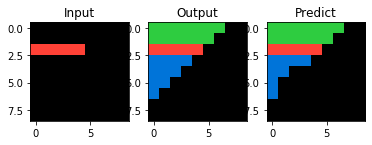

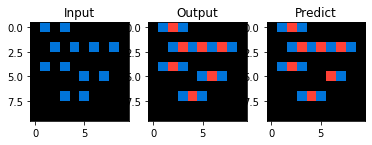

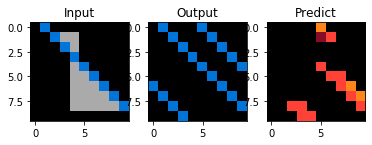

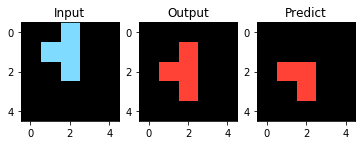

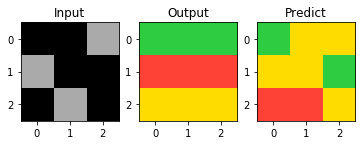

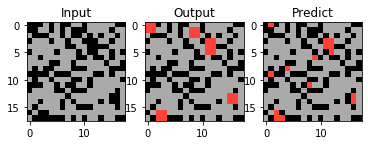

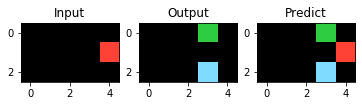

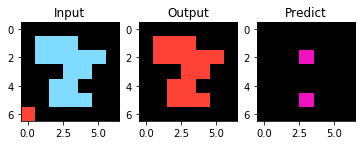

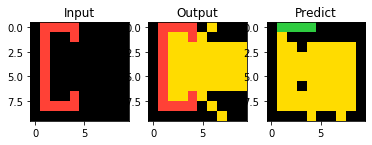

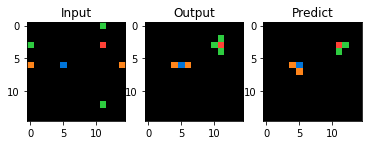

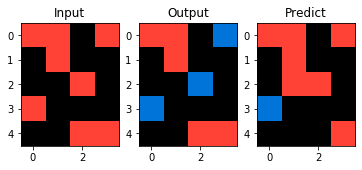

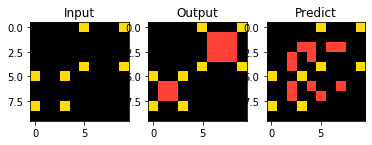

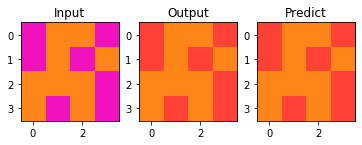

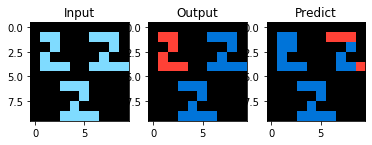

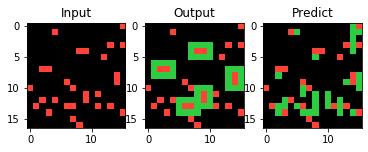

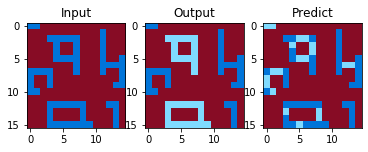

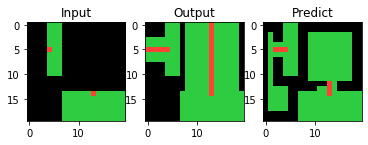

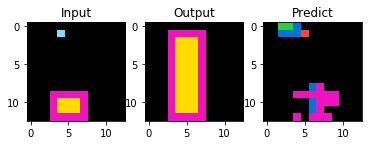

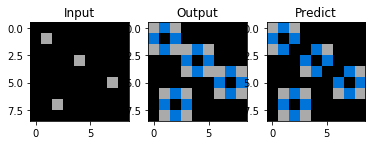

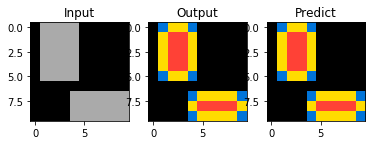

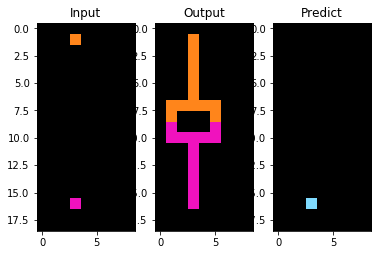

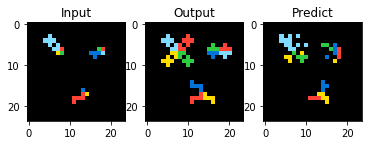

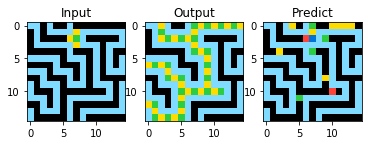

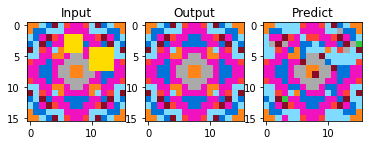

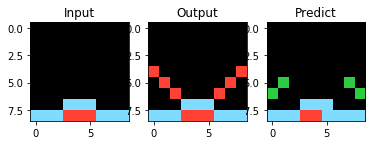

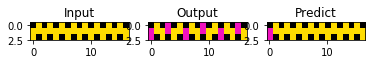

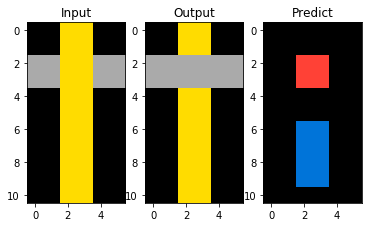

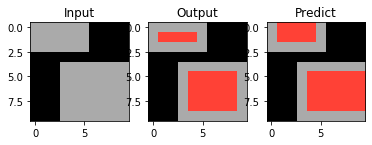

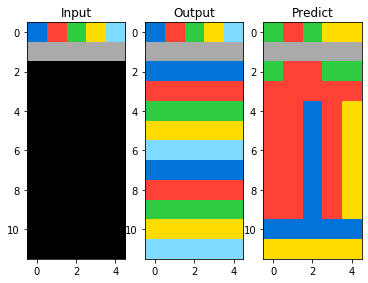

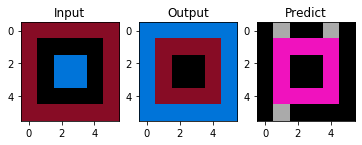

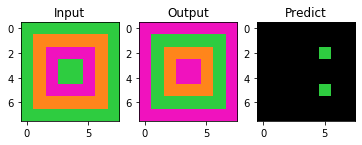

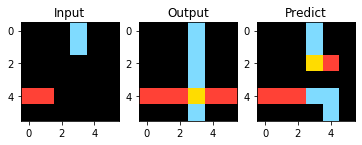

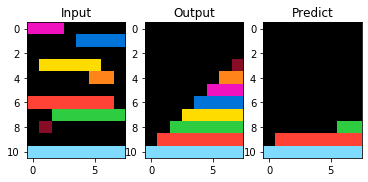

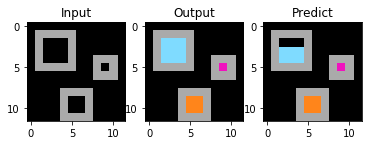

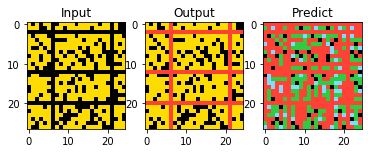

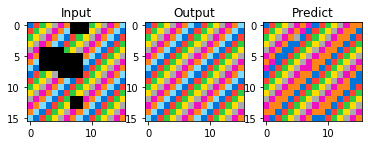

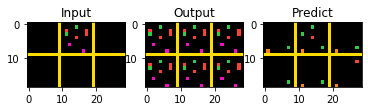

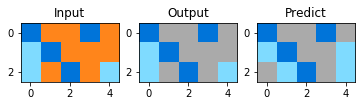

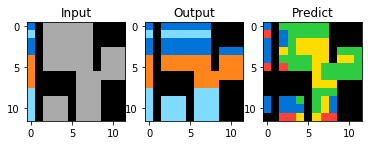

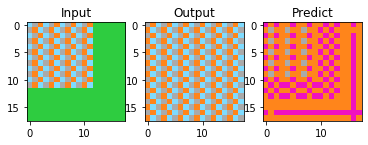

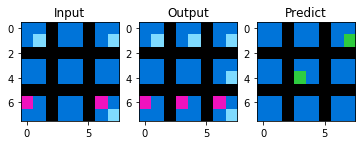

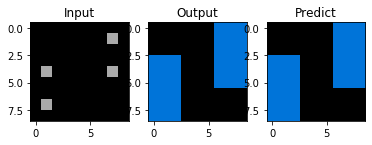

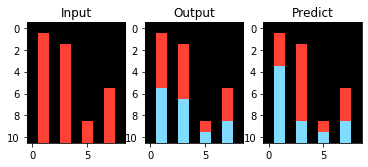

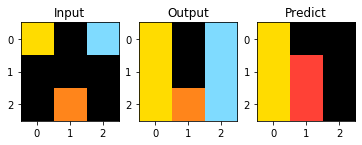

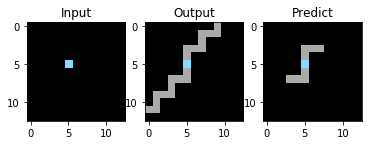

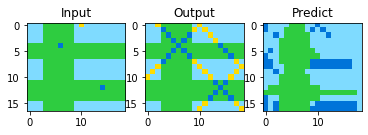

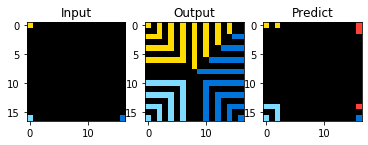

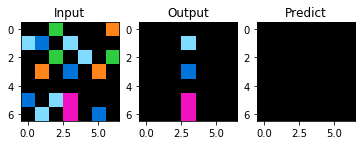

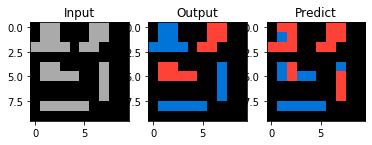

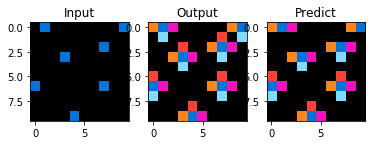

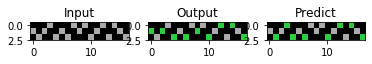

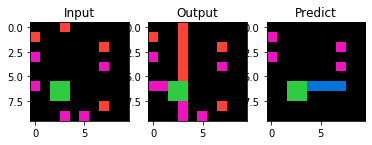

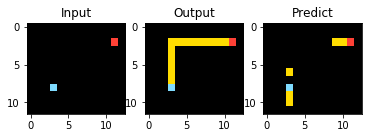

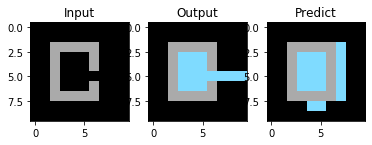

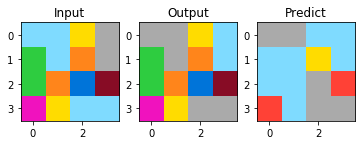

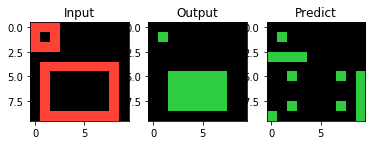

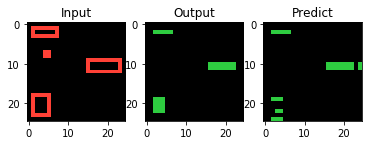

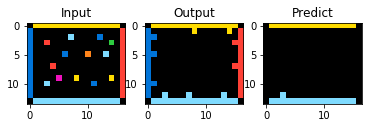

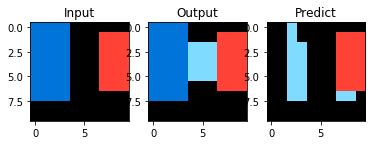

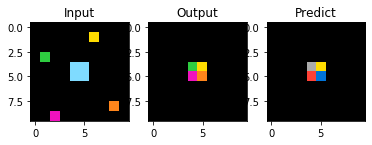

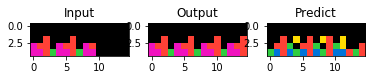

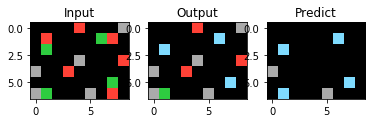

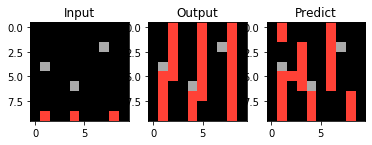

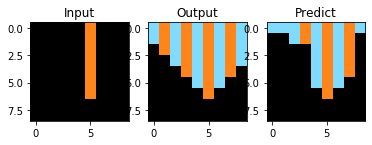

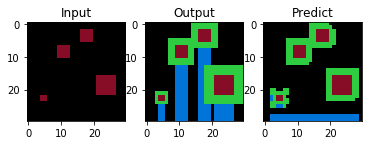

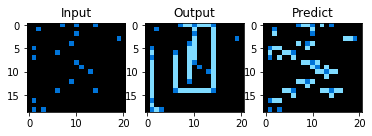

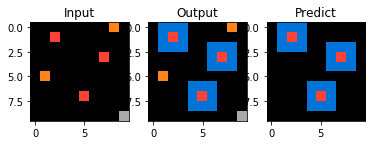

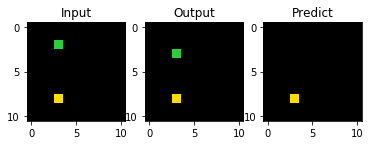

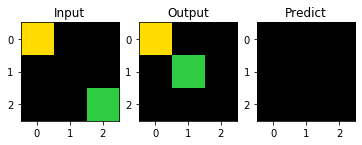

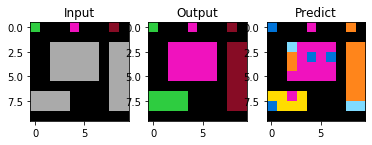

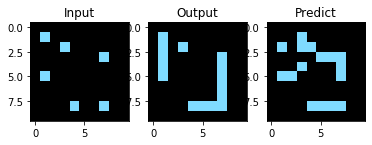

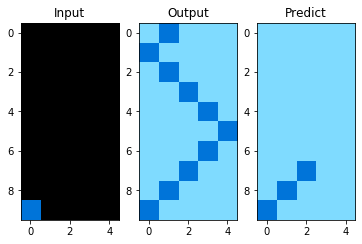

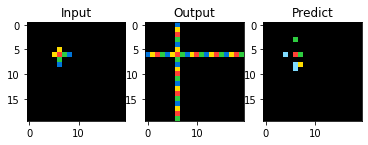

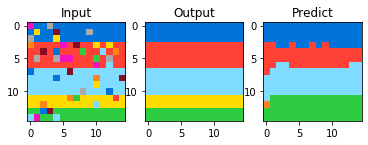

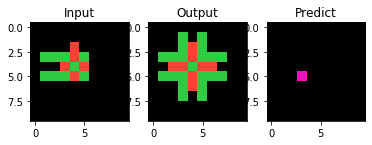

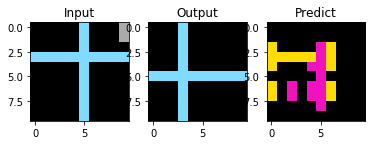

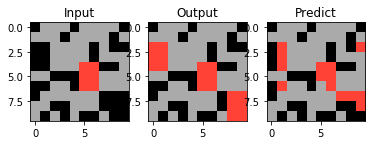

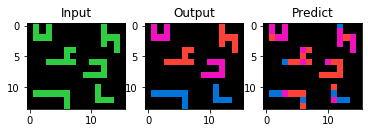

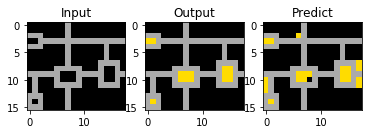

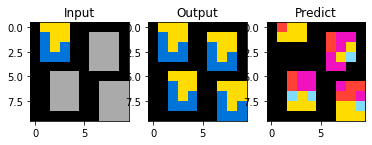

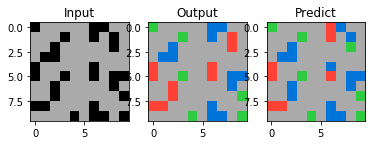

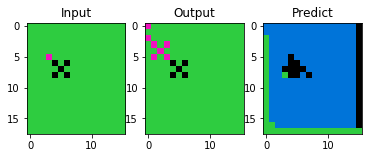

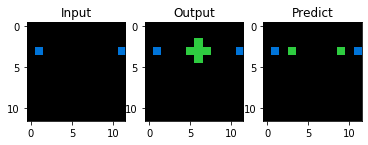

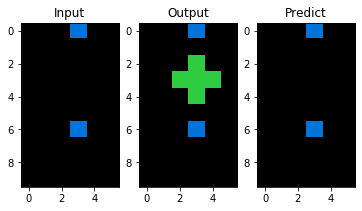

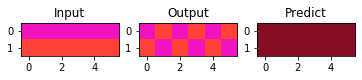

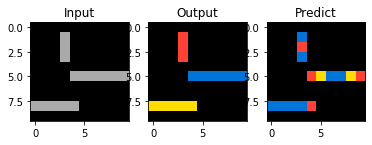

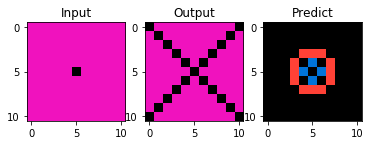

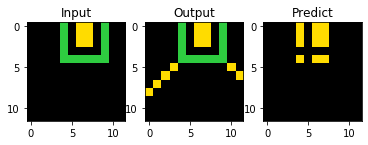

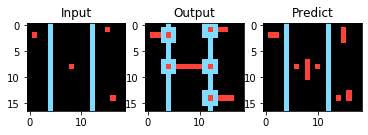

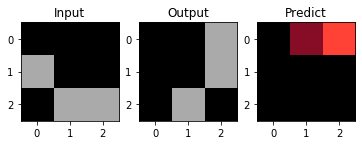

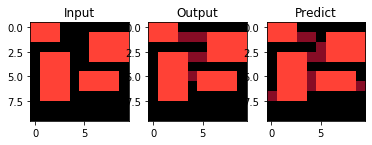

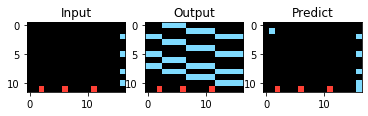

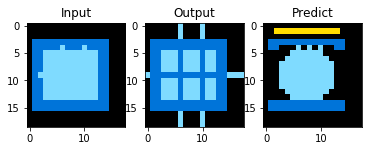

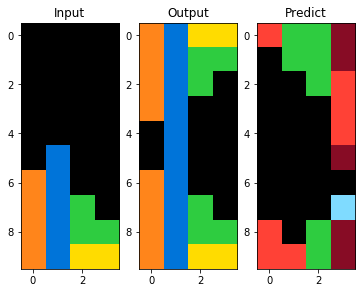

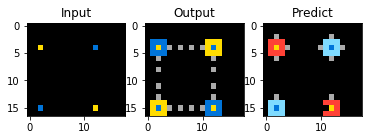

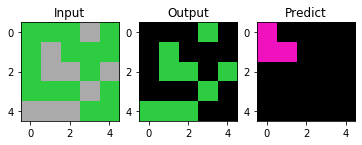

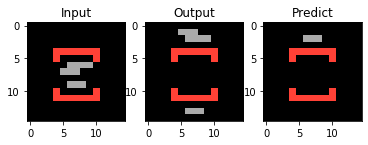

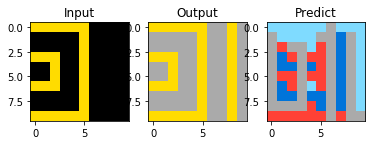

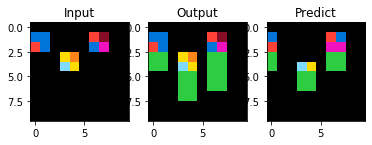

In [31]:
for task, prediction in tqdm(zip(train_tasks, train_predictions)):
    if input_output_shape_is_same(task):
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])